## Imports

In [43]:
# Core data handling
import pandas as pd
import numpy as np

# Plotting & visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Time-series modeling
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Utilities
import warnings
warnings.filterwarnings('ignore')  # hides warning messages for cleaner output

# Set plot style  (for nicer graphs)
plt.style.use('seaborn-v0_8')  

# For saving trained model
import pickle
import os

In [44]:
# !pip install prophet

## Load and Prepare the Data

In [45]:
# Load the dataset
df = pd.read_csv('mumbai-monthly-rains.csv')
df

,Year,Jan,Feb,Mar,April,May,June,July,Aug,Sept,Oct,Nov,Dec,Total
0,1901,13.116602,0.000000,0.000000,3.949669,17.139791,640.714036,888.369692,545.045796,64.271513,9.871696,0.000000,0.000000,2182.478796
1,1902,0.000000,0.000000,0.000000,0.000000,0.355001,247.998782,408.433730,566.595863,688.913455,28.654092,0.488864,19.526547,1960.966334
2,1903,0.000000,0.000000,0.844034,0.000000,220.568740,370.849048,902.447896,602.420828,264.589816,157.892877,0.000000,0.000000,2519.613240
3,1904,0.000000,0.000000,11.381769,0.000000,0.000000,723.081969,390.886799,191.581927,85.704754,38.679948,0.000000,0.000000,1441.317168
4,1905,0.662561,1.713452,0.000000,0.000000,0.000000,123.870892,581.827975,167.382149,172.297723,7.365924,24.903575,0.000000,1080.024250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017,0.000000,0.000000,0.000000,0.000000,1.043890,584.946748,702.386594,796.997046,539.932782,102.108135,0.000000,79.685446,2807.100642
117,2018,0.000000,0.000000,0.000000,0.000000,0.000000,846.855987,913.470461,228.590420,78.935944,13.354574,8.939212,0.000000,2090.146599
118,2019,0.000000,0.000000,0.000000,0.000000,0.000000,412.763730,1302.466441,479.834603,987.796660,92.008442,57.014501,1.172425,3333.056801
119,2020,0.000000,0.000000,0.104274,0.000000,0.000000,439.814569,1328.766631,1182.080688,411.247678,184.458385,0.000000,16.787305,3563.259531


In [46]:
df = df.drop(columns=['Total'])                   # The yearly total isn’t needed and could confuse the model
df 

,Year,Jan,Feb,Mar,April,May,June,July,Aug,Sept,Oct,Nov,Dec
0,1901,13.116602,0.000000,0.000000,3.949669,17.139791,640.714036,888.369692,545.045796,64.271513,9.871696,0.000000,0.000000
1,1902,0.000000,0.000000,0.000000,0.000000,0.355001,247.998782,408.433730,566.595863,688.913455,28.654092,0.488864,19.526547
2,1903,0.000000,0.000000,0.844034,0.000000,220.568740,370.849048,902.447896,602.420828,264.589816,157.892877,0.000000,0.000000
3,1904,0.000000,0.000000,11.381769,0.000000,0.000000,723.081969,390.886799,191.581927,85.704754,38.679948,0.000000,0.000000
4,1905,0.662561,1.713452,0.000000,0.000000,0.000000,123.870892,581.827975,167.382149,172.297723,7.365924,24.903575,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017,0.000000,0.000000,0.000000,0.000000,1.043890,584.946748,702.386594,796.997046,539.932782,102.108135,0.000000,79.685446
117,2018,0.000000,0.000000,0.000000,0.000000,0.000000,846.855987,913.470461,228.590420,78.935944,13.354574,8.939212,0.000000
118,2019,0.000000,0.000000,0.000000,0.000000,0.000000,412.763730,1302.466441,479.834603,987.796660,92.008442,57.014501,1.172425
119,2020,0.000000,0.000000,0.104274,0.000000,0.000000,439.814569,1328.766631,1182.080688,411.247678,184.458385,0.000000,16.787305


In [47]:
# Define month names exactly as in your file
months = ['Jan','Feb','Mar','April','May','June','July','Aug','Sept','Oct','Nov','Dec']

# Reshape: 1 row per month (not per year)
df_long = df.melt(
    id_vars='Year',           # Keep 'Year' as identifier
    value_vars=months,        # Columns to unpivot
    var_name='Month',         # New column: month name
    value_name='Rainfall'     # New column: rainfall value
)

In [48]:
df_long

,Year,Month,Rainfall
0,1901,Jan,13.116602
1,1902,Jan,0.000000
2,1903,Jan,0.000000
3,1904,Jan,0.000000
4,1905,Jan,0.662561
...,...,...,...
1447,2017,Dec,79.685446
1448,2018,Dec,0.000000
1449,2019,Dec,1.172425
1450,2020,Dec,16.787305


In [49]:
month_to_num = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df_long['Month_Num'] = df_long['Month'].map(month_to_num)

In [50]:
# Combine Year and Month_Num into a real date
df_long['Date'] = pd.to_datetime(
    df_long['Year'].astype(str) + '-' + df_long['Month_Num'].astype(str)
)

# Sort by date (just to be safe)
df_long = df_long.sort_values('Date').reset_index(drop=True)

In [51]:
df_long

,Year,Month,Rainfall,Month_Num,Date
0,1901,Jan,13.116602,1,1901-01-01
1,1901,Feb,0.000000,2,1901-02-01
2,1901,Mar,0.000000,3,1901-03-01
3,1901,April,3.949669,4,1901-04-01
4,1901,May,17.139791,5,1901-05-01
...,...,...,...,...,...
1447,2021,Aug,323.199896,8,2021-08-01
1448,2021,Sept,601.247517,9,2021-09-01
1449,2021,Oct,36.040432,10,2021-10-01
1450,2021,Nov,25.156942,11,2021-11-01


In [52]:
# Final clean time-series
ts_data = df_long[['Date', 'Rainfall']].copy()
ts_data.set_index('Date', inplace=True)

In [53]:
print("Data range:", ts_data.index.min(), "to", ts_data.index.max())
print("Total months:", len(ts_data))
print("\nFirst 5 rows:")
print(ts_data.head())
print("\nLast 5 rows:")
print(ts_data.tail())

Data range: 1901-01-01 00:00:00 to 2021-12-01 00:00:00
Total months: 1452

First 5 rows:
             Rainfall
Date                 
1901-01-01  13.116602
1901-02-01   0.000000
1901-03-01   0.000000
1901-04-01   3.949669
1901-05-01  17.139791

Last 5 rows:
              Rainfall
Date                  
2021-08-01  323.199896
2021-09-01  601.247517
2021-10-01   36.040432
2021-11-01   25.156942
2021-12-01   90.044602


In [54]:
ts_data.to_csv('mumbai_rainfall_clean_1901_2021.csv')

## Exploratory Data Analysis (EDA)

In [55]:
# Copy data to avoid modifying original
df_eda = ts_data.copy()

# Extract year and month
df_eda['Year'] = df_eda.index.year
df_eda['Month'] = df_eda.index.month

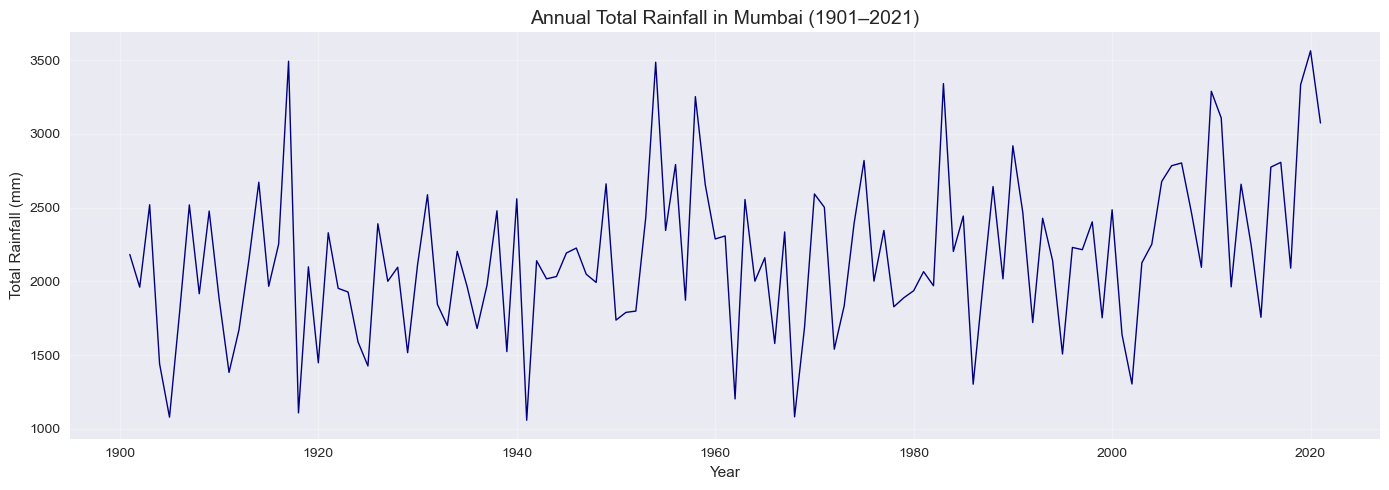

In [56]:
# Plotting yearly total rainfall (1901–2021)

yearly_rain = df_eda.groupby('Year')['Rainfall'].sum()

plt.figure(figsize=(14, 5))
plt.plot(yearly_rain.index, yearly_rain.values, color='navy', linewidth=1)
plt.title('Annual Total Rainfall in Mumbai (1901–2021)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

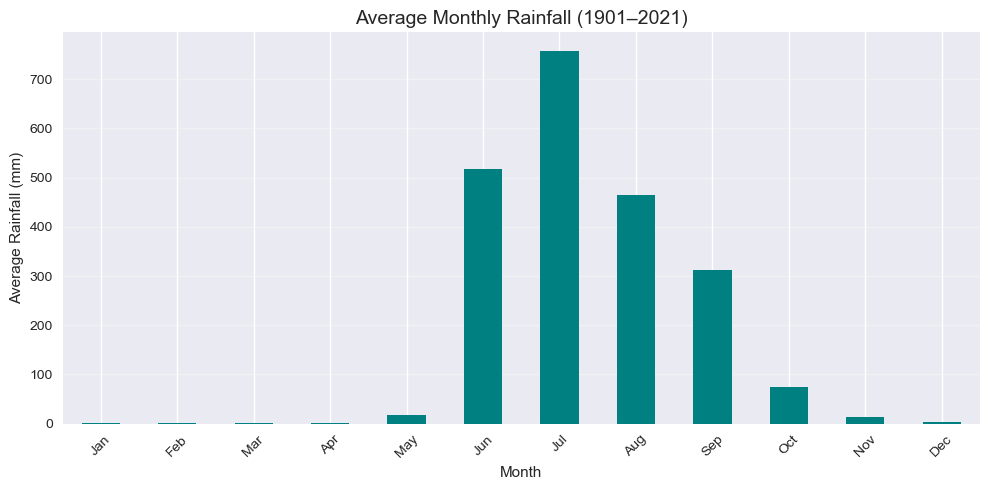

In [57]:
# Plotting average rainfall by month (seasonality)
monthly_avg = df_eda.groupby('Month')['Rainfall'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='teal')
plt.title('Average Monthly Rainfall (1901–2021)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.xticks(
    ticks=range(12),
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    rotation=45
)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

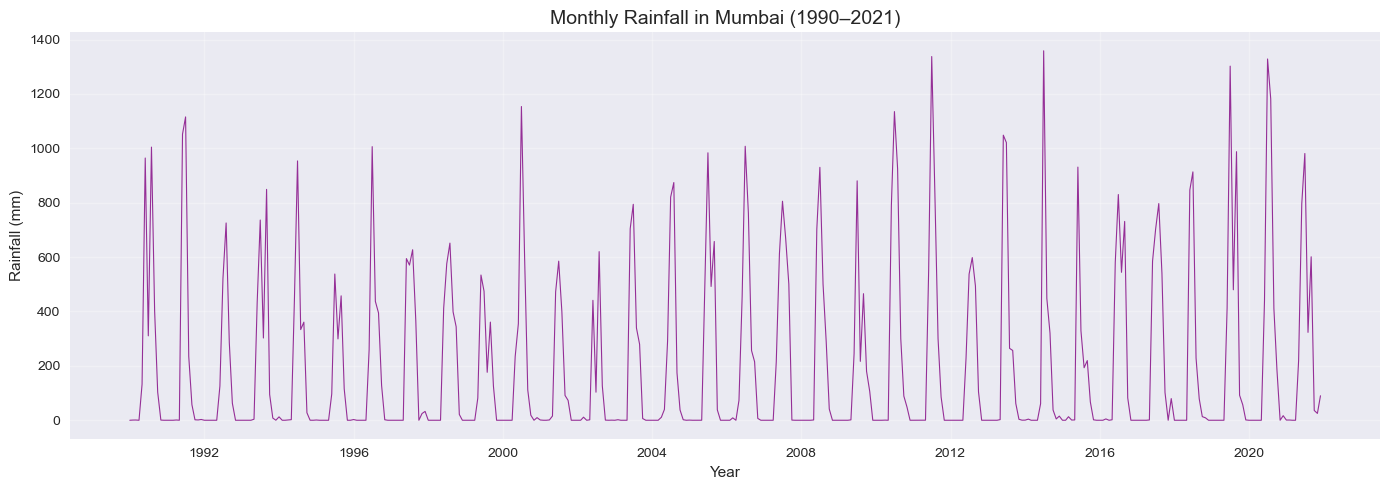

In [58]:
# Plotting full time-series (last 30 years for clarity)
recent = df_eda[df_eda.index >= '1990']

plt.figure(figsize=(14, 5))
plt.plot(recent.index, recent['Rainfall'], color='purple', alpha=0.8, linewidth=0.8)
plt.title('Monthly Rainfall in Mumbai (1990–2021)', fontsize=14)
plt.ylabel('Rainfall (mm)')
plt.xlabel('Year')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

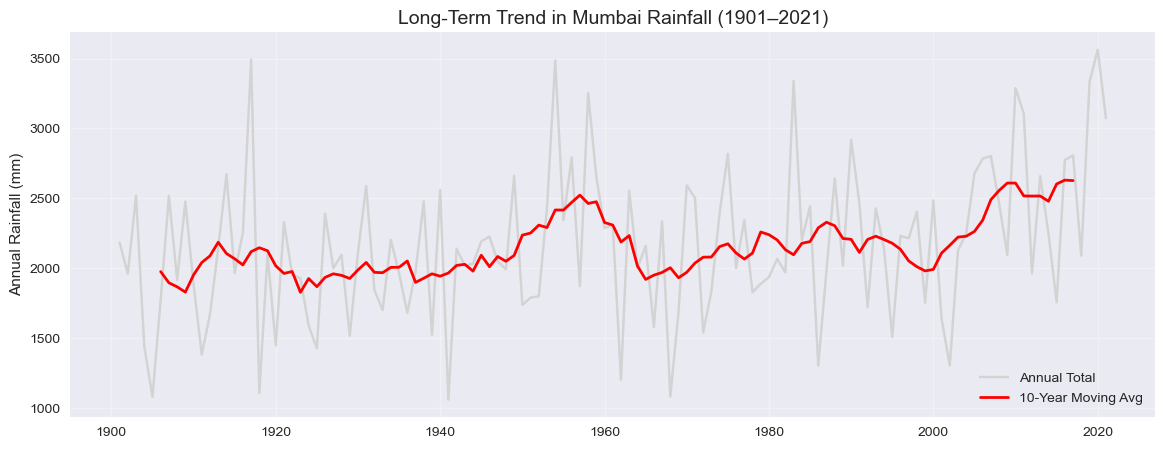

In [59]:
# Checking for Long-Term Trend (Is rainfall increasing?)

# Resample to yearly total
yearly = df_eda.groupby('Year')['Rainfall'].sum()

# 10-year moving average
yearly_ma = yearly.rolling(window=10, center=True).mean()

plt.figure(figsize=(14, 5))
plt.plot(yearly.index, yearly.values, color='lightgray', label='Annual Total')
plt.plot(yearly_ma.index, yearly_ma.values, color='red', linewidth=2, label='10-Year Moving Avg')
plt.title('Long-Term Trend in Mumbai Rainfall (1901–2021)', fontsize=14)
plt.ylabel('Annual Rainfall (mm)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

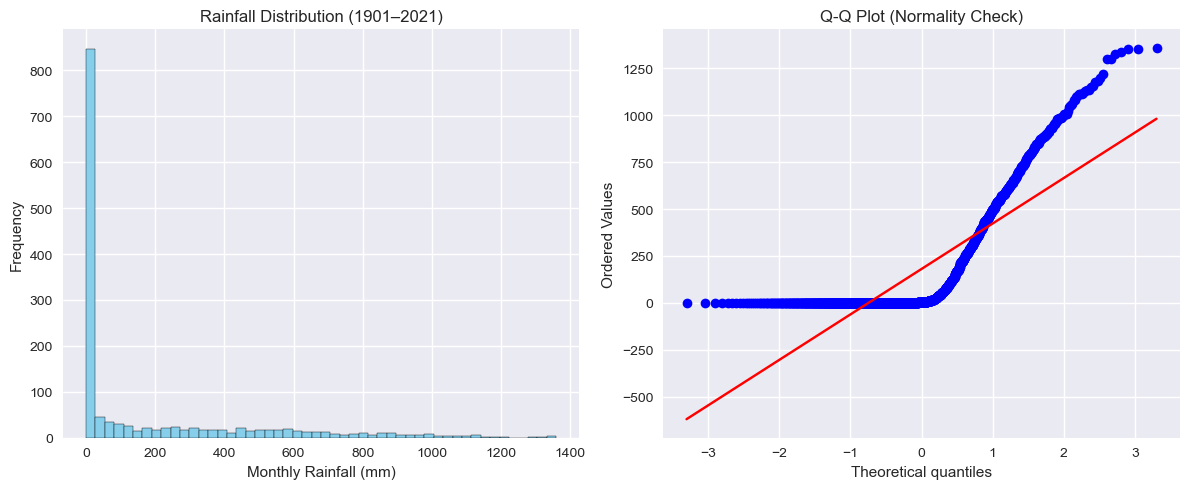

In [60]:
# Distribution of Rainfall
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df_eda['Rainfall'], bins=50, color='skyblue', edgecolor='black')
plt.title('Rainfall Distribution (1901–2021)')
plt.xlabel('Monthly Rainfall (mm)')
plt.ylabel('Frequency')

# Q-Q plot (optional: check normality)
from scipy import stats
plt.subplot(1, 2, 2)
stats.probplot(ts_data['Rainfall'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.show()

In [61]:
# Check for data issues
print("Rainfall statistics:")
print(f"Min: {df_eda['Rainfall'].min():.2f} mm")
print(f"Max: {df_eda['Rainfall'].max():.2f} mm")
print(f"Mean: {df_eda['Rainfall'].mean():.2f} mm")

# Count zero-rain months
zero_months = (df_eda['Rainfall'] == 0).sum()
print(f"\nMonths with 0 mm rain: {zero_months} out of {len(df_eda)} ({zero_months/len(df_eda)*100:.1f}%)")

Rainfall statistics:
Min: 0.00 mm
Max: 1358.83 mm
Mean: 180.68 mm

Months with 0 mm rain: 564 out of 1452 (38.8%)


## Feature Engineering & Train-Test Split

In [62]:
# Work on a copy to avoid changing original EDA data
df_model = ts_data[['Rainfall']].copy()

In [63]:
# Extract month (1–12) — captures seasonality
df_model['Month'] = df_model.index.month

In [64]:
# Create lagged features: last 1, 2, and 3 months
df_model['Lag1'] = df_model['Rainfall'].shift(1)   # Rainfall last month
df_model['Lag2'] = df_model['Rainfall'].shift(2)   # Rainfall 2 months ago
df_model['Lag3'] = df_model['Rainfall'].shift(3)   # Rainfall 3 months ago

# Remove rows with NaN (first 3 months have no lags)
df_model = df_model.dropna()

In [65]:
df_model

,Rainfall,Month,Lag1,Lag2,Lag3
Date,,,,,
1901-04-01,3.949669,4,0.000000,0.000000,13.116602
1901-05-01,17.139791,5,3.949669,0.000000,0.000000
1901-06-01,640.714036,6,17.139791,3.949669,0.000000
1901-07-01,888.369692,7,640.714036,17.139791,3.949669
1901-08-01,545.045796,8,888.369692,640.714036,17.139791
...,...,...,...,...,...
2021-08-01,323.199896,8,981.146645,796.307275,219.075060
2021-09-01,601.247517,9,323.199896,981.146645,796.307275
2021-10-01,36.040432,10,601.247517,323.199896,981.146645


In [66]:
# Features: Month + last 3 months of rainfall
X = df_model[['Month', 'Lag1', 'Lag2', 'Lag3']]

# Target: Current month's rainfall
y = df_model['Rainfall']

In [67]:
X

,Month,Lag1,Lag2,Lag3
Date,,,,
1901-04-01,4,0.000000,0.000000,13.116602
1901-05-01,5,3.949669,0.000000,0.000000
1901-06-01,6,17.139791,3.949669,0.000000
1901-07-01,7,640.714036,17.139791,3.949669
1901-08-01,8,888.369692,640.714036,17.139791
...,...,...,...,...
2021-08-01,8,981.146645,796.307275,219.075060
2021-09-01,9,323.199896,981.146645,796.307275
2021-10-01,10,601.247517,323.199896,981.146645


In [68]:
y

Date
1901-04-01      3.949669
1901-05-01     17.139791
1901-06-01    640.714036
1901-07-01    888.369692
1901-08-01    545.045796
                 ...    
2021-08-01    323.199896
2021-09-01    601.247517
2021-10-01     36.040432
2021-11-01     25.156942
2021-12-01     90.044602
Name: Rainfall, Length: 1449, dtype: float64

In [69]:
# Find the split index
split_date = '2017-01-01'

# Split
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# Confirm shapes
print(f"Training period: {X_train.index.min()} → {X_train.index.max()}")
print(f"Test period: {X_test.index.min()} → {X_test.index.max()}")
print(f"\nTrain samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training period: 1901-04-01 00:00:00 → 2016-12-01 00:00:00
Test period: 2017-01-01 00:00:00 → 2021-12-01 00:00:00

Train samples: 1389
Test samples: 60


## Model Training & Evaluation

In [70]:
# Dictionary to store results
results = {}

In [71]:
## Model 1: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

results['Random Forest'] = {'MAE': mae_rf, 'RMSE': rmse_rf, 'pred': y_pred_rf}
print(f"Random Forest → MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")

Random Forest → MAE: 99.92, RMSE: 196.00


In [72]:
## Model 2: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

results['Linear Regression'] = {'MAE': mae_lr, 'RMSE': rmse_lr, 'pred': y_pred_lr}
print(f"Linear Regression → MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")

Linear Regression → MAE: 200.39, RMSE: 291.58


In [73]:
## Model 3: ARIMA (AutoRegressive Integrated Moving Average)
# Use full historical series (up to 2016) for training
train_arima = ts_data[ts_data.index < '2017-01-01']['Rainfall']
test_arima = ts_data[ts_data.index >= '2017-01-01']['Rainfall']

# Fit SARIMA (Seasonal ARIMA) — monthly data → seasonal_order=(1,1,1,12)
# But start with basic ARIMA(1,1,1) if SARIMA is slow
try:
    arima_model = ARIMA(train_arima, order=(1,1,1), seasonal_order=(1,1,1,12))
    arima_fit = arima_model.fit()
    
    # Forecast 60 steps ahead (2017–2021)
    arima_pred = arima_fit.forecast(steps=60)
    
    mae_arima = mean_absolute_error(test_arima, arima_pred)
    rmse_arima = np.sqrt(mean_squared_error(test_arima, arima_pred))
    
    results['SARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima, 'pred': arima_pred}
    print(f"SARIMA → MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
    
except Exception as e:
    print("SARIMA failed:", e)
    # Fallback to simple ARIMA
    arima_model = ARIMA(train_arima, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=60)
    mae_arima = mean_absolute_error(test_arima, arima_pred)
    rmse_arima = np.sqrt(mean_squared_error(test_arima, arima_pred))
    results['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima, 'pred': arima_pred}
    print(f"ARIMA → MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

SARIMA → MAE: 108.95, RMSE: 194.83


In [74]:
## Model 4: Prophet 
# Prepare Prophet dataframe
prophet_df = ts_data.reset_index()[['Date', 'Rainfall']].rename(columns={'Date': 'ds', 'Rainfall': 'y'})

# Train on data before 2017
train_prophet = prophet_df[prophet_df['ds'] < '2017-01-01']

# Initialize and fit
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_prior_scale=10,
    changepoint_prior_scale=0.05
)
prophet_model.fit(train_prophet)

# Create future dataframe (monthly)
future = prophet_model.make_future_dataframe(periods=60, freq='MS')  # MS = month start
forecast = prophet_model.predict(future)

# Extract predictions for test period (2017–2021)
prophet_pred = forecast.set_index('ds').loc[y_test.index, 'yhat']

mae_p = mean_absolute_error(y_test, prophet_pred)
rmse_p = np.sqrt(mean_squared_error(y_test, prophet_pred))

results['Prophet'] = {'MAE': mae_p, 'RMSE': rmse_p, 'pred': prophet_pred}
print(f"Prophet → MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}")

17:09:42 - cmdstanpy - INFO - Chain [1] start processing
17:09:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet → MAE: 110.26, RMSE: 198.11


In [75]:
# Create comparison table
comparison = pd.DataFrame({
    model: {'MAE': res['MAE'], 'RMSE': res['RMSE']}
    for model, res in results.items()
}).T

comparison = comparison.sort_values('MAE')
print("\n Model Comparison (Lower = Better):")
print(comparison.round(2))


 Model Comparison (Lower = Better):
                      MAE    RMSE
Random Forest       99.92  196.00
SARIMA             108.95  194.83
Prophet            110.26  198.11
Linear Regression  200.39  291.58


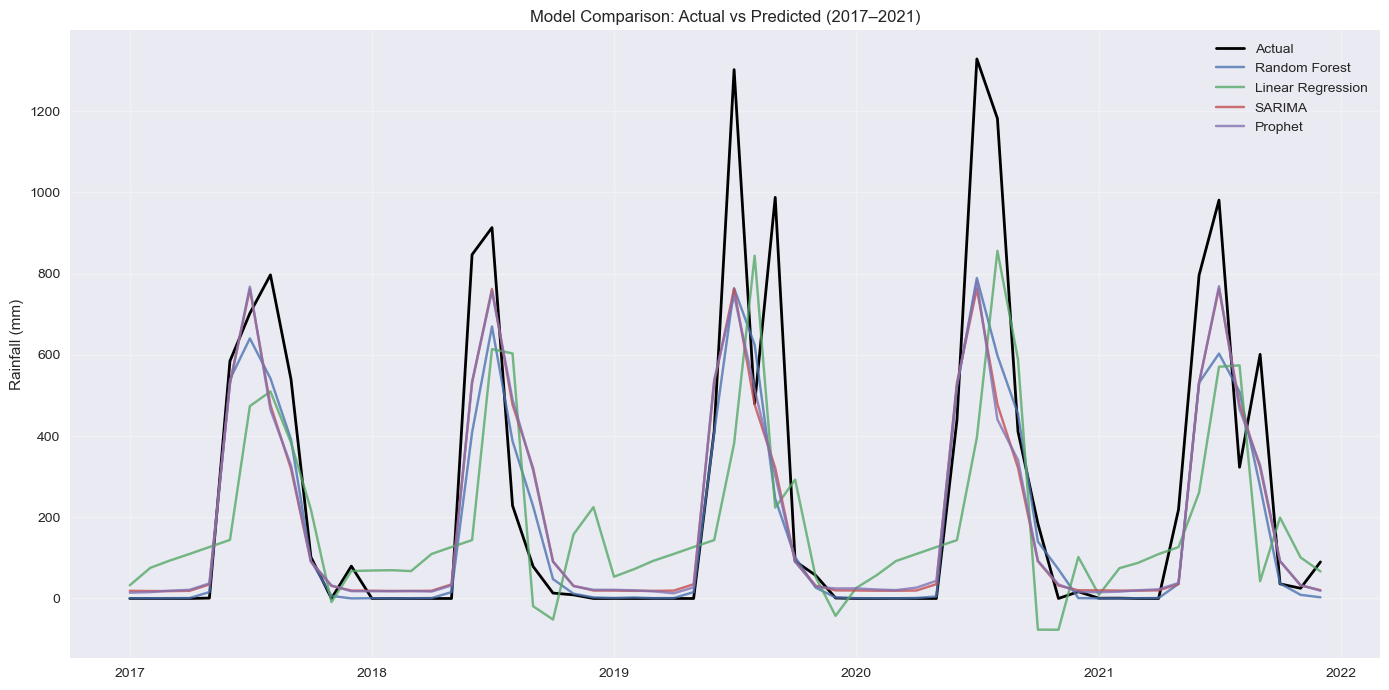

In [76]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)

for model_name, res in results.items():
    plt.plot(y_test.index, res['pred'], label=model_name, alpha=0.8)

plt.title('Model Comparison: Actual vs Predicted (2017–2021)')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Hyperparameter Tuning with TimeSeriesSplit
# Define search space
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Time-series cross-validation (no future leakage)
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

# Fit
rf_random.fit(X_train, y_train)

# Best model
rf_tuned = rf_random.best_estimator_
y_pred_tuned = rf_tuned.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print("Tuning complete!")
print(f"Best MAE (CV): {-rf_random.best_score_:.2f} mm")
print(f"Tuned RF MAE (2017–2021): {mae_tuned:.2f} mm")
print("Best params:", rf_random.best_params_)

Tuning complete!
Best MAE (CV): 79.65 mm
Tuned RF MAE (2017–2021): 100.17 mm
Best params: {'n_estimators': 150, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 5}


In [78]:
# Ensure the output directory exists
model_dir = 'Trained_Model'
os.makedirs(model_dir, exist_ok=True)

# Save the best model (Random Forest) to disk
model_path = os.path.join(model_dir, 'rainfall_forecast_rf_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(rf, f)

print(f"Best model (Random Forest) saved successfully to: {model_path}")

# Save feature names
feature_names = X_train.columns.tolist()
feature_path = os.path.join(model_dir, 'feature_names.pkl')
with open(feature_path, 'wb') as f:
    pickle.dump(feature_names, f)

print(f"Feature names saved to: {feature_path}")

Best model (Random Forest) saved successfully to: Trained_Model\rainfall_forecast_rf_model.pkl
Feature names saved to: Trained_Model\feature_names.pkl


## Forecast Future Rainfall (2022–2025)

In [79]:
# Load model and features
with open('Trained_Model/rainfall_forecast_rf_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('Trained_Model/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print("Model and features loaded successfully.")
print("Features used:", feature_names)

Model and features loaded successfully.
Features used: ['Month', 'Lag1', 'Lag2', 'Lag3']


In [80]:
# Last 3 months (Dec = Lag1, Nov = Lag2, Oct = Lag3)
lag1 = 90.04460216   # Dec 2021
lag2 = 25.15694219   # Nov 2021
lag3 = 36.04043196   # Oct 2021

In [81]:
forecast_months = 48  # Jan 2022 to Dec 2025
future_dates = []
future_predictions = []

# Start forecasting from Jan 2022
current_date = pd.to_datetime('2022-01-01')

In [82]:
for i in range(forecast_months):
    # Get month (1–12)
    month = current_date.month
    
    # Create input array in correct feature order
    X_input = np.array([[month, lag1, lag2, lag3]])
    
    # Predict
    pred = model.predict(X_input)[0]
    
    # Enforce non-negative rainfall
    pred = max(pred, 0)
    
    # Store
    future_dates.append(current_date)
    future_predictions.append(pred)
    
    # Update lags: shift window forward
    lag3 = lag2
    lag2 = lag1
    lag1 = pred
    
    # Move to next month
    current_date += pd.DateOffset(months=1)

print(f"Forecast completed for {forecast_months} months (2022–2025).")

Forecast completed for 48 months (2022–2025).


In [83]:
# Create DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast_Rainfall_mm': future_predictions
})
forecast_df.set_index('Date', inplace=True)

# Save to CSV
forecast_df.to_csv('mumbai_rainfall_forecast_2022_2025.csv')

print("Forecast saved to: mumbai_rainfall_forecast_2022_2025.csv")
print("\nFirst 12 months:")
print(forecast_df.head(12))

Forecast saved to: mumbai_rainfall_forecast_2022_2025.csv

First 12 months:
            Forecast_Rainfall_mm
Date                            
2022-01-01              0.857719
2022-02-01              0.238791
2022-03-01              1.532999
2022-04-01              1.308633
2022-05-01             18.659540
2022-06-01            550.792954
2022-07-01            846.857964
2022-08-01            473.693046
2022-09-01            326.700472
2022-10-01             36.266222
2022-11-01             20.744925
2022-12-01              4.349164


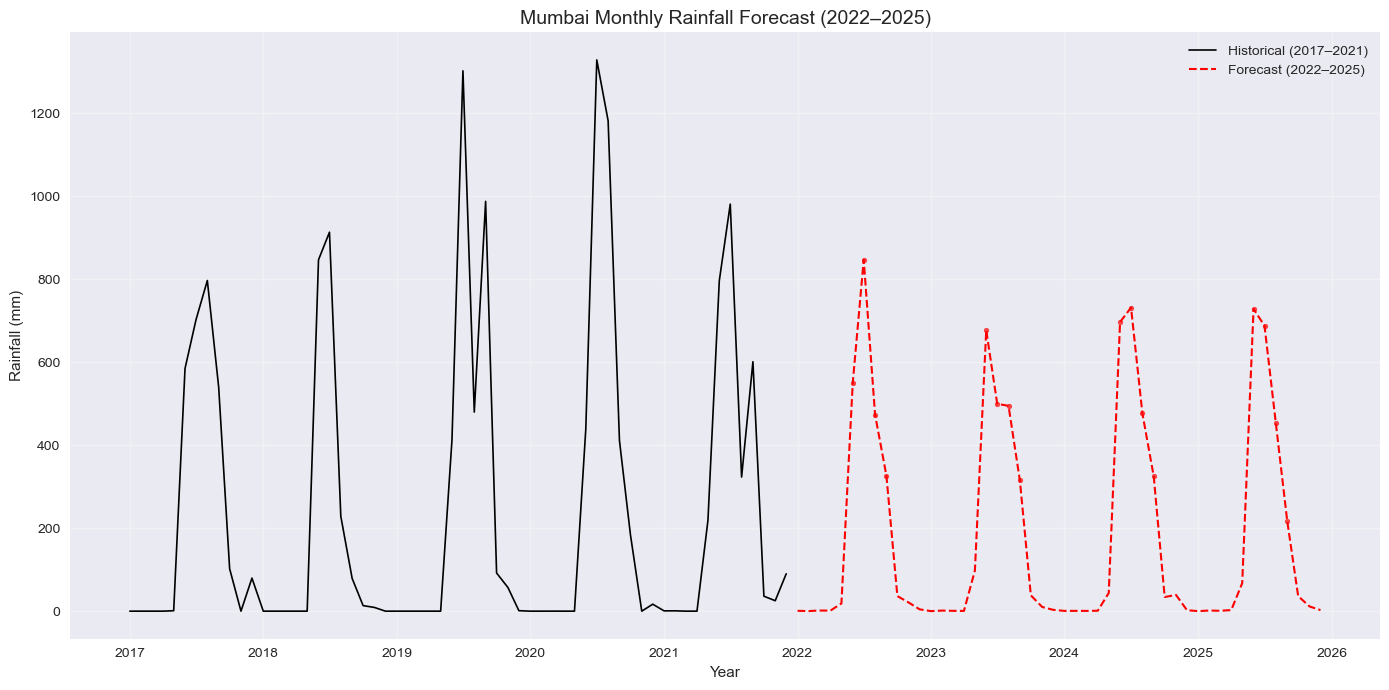

In [84]:
# Load original data for plotting (last 5 years)
df_original = pd.read_csv('mumbai-monthly-rains.csv')
# Reshape to time-series (same as Phase 1)
months = ['Jan','Feb','Mar','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
df_long = df_original.drop(columns=['Total']).melt(
    id_vars='Year', value_vars=months, var_name='Month', value_name='Rainfall'
)
month_map = {'Jan':1,'Feb':2,'Mar':3,'April':4,'May':5,'June':6,
             'July':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}
df_long['Month_Num'] = df_long['Month'].map(month_map)
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month_Num'].astype(str))
ts_full = df_long.set_index('Date')[['Rainfall']].sort_index()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(ts_full.loc['2017-01-01':].index, ts_full.loc['2017-01-01':]['Rainfall'],
         label='Historical (2017–2021)', color='black', linewidth=1.2)

plt.plot(forecast_df.index, forecast_df['Forecast_Rainfall_mm'],
         label='Forecast (2022–2025)', color='red', linestyle='--', linewidth=1.5)

# Highlight monsoon in forecast
monsoon = forecast_df[forecast_df.index.month.isin([6,7,8,9])]
plt.scatter(monsoon.index, monsoon['Forecast_Rainfall_mm'], 
            color='red', s=12, alpha=0.7)

plt.title('Mumbai Monthly Rainfall Forecast (2022–2025)', fontsize=14)
plt.ylabel('Rainfall (mm)')
plt.xlabel('Year')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()